In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as scs
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [66]:
master_database=pd.read_csv("/Users/jenniferwu/Documents/kaggle-competition1/cleaned_data/train_spray_weather_v1.csv",float_precision='round_trip')

In [67]:
master_database.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'WnvPresent', 'NumMosquitos', 'year', 'month', 'day',
       'dist_2011-08-29 00:00:00', 'dist_2011-09-07 00:00:00',
       'dist_2013-07-17 00:00:00', 'dist_2013-07-25 00:00:00',
       'dist_2013-08-08 00:00:00', 'dist_2013-08-15 00:00:00',
       'dist_2013-08-16 00:00:00', 'dist_2013-08-22 00:00:00',
       'dist_2013-08-29 00:00:00', 'dist_2013-09-05 00:00:00',
       'days_2011-08-29 00:00:00', 'days_2011-09-07 00:00:00',
       'days_2013-07-17 00:00:00', 'days_2013-07-25 00:00:00',
       'days_2013-08-08 00:00:00', 'days_2013-08-15 00:00:00',
       'days_2013-08-16 00:00:00', 'days_2013-08-22 00:00:00',
       'days_2013-08-29 00:00:00', 'days_2013-09-05 00:00:00', 'trap_dist_st1',
       'trap_dist_st2', 'Station', 'WeatherLat_Station', 'WeatherLon_Station',
       'Tmax_Station', 'Tmin_Station', 'Tavg_Station', 'Depart_Station',

In [68]:
master_database['min_spary_dist']=master_database.iloc[:,15:25].min(axis=1)
master_database['min_spary_days']=master_database.iloc[:,26:34].min(axis=1)

In [69]:
master_database1 = master_database.drop(columns = master_database.iloc[:,15:35], axis =1)

In [70]:
master_database1.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'WnvPresent', 'NumMosquitos', 'year', 'month', 'day', 'trap_dist_st1',
       'trap_dist_st2', 'Station', 'WeatherLat_Station', 'WeatherLon_Station',
       'Tmax_Station', 'Tmin_Station', 'Tavg_Station', 'Depart_Station',
       'DewPoint_Station', 'WetBulb_Station', 'Heat_Station', 'Cool_Station',
       'CodeSum_Station', 'PrecipTotal_Station', 'StnPressure_Station',
       'SeaLevel_Station', 'ResultSpeed_Station', 'ResultDir_Station',
       'AvgSpeed_Station', 'Sunrise_Station', 'Sunset_Station',
       'WetBulb_Station_c', 'Tavg_Station_c', 'rel_hum_station', 'BCFG', 'BR',
       'DZ', 'FG', 'FGplus_', 'FU', 'GR', 'HZ', 'NO_EVENT', 'RA', 'SN', 'SQ',
       'TS', 'TSRA', 'VCFG', 'VCTS', 'min_spary_dist', 'min_spary_days'],
      dtype='object')

##  Chi Squared Test : CodeSum and other Categorical Vars in Relation to WNV Present

In [71]:
cordf = master_database[['Street', 'Trap','Address','Block','BCFG', 'BR','DZ', 'FG', 'FGplus_', 'FU', 'GR', 'HZ', 'NO_EVENT', 'RA', 'SN', 'SQ',
                'TS', 'TSRA', 'VCFG', 'VCTS','Sunrise_Station','Sunset_Station','WnvPresent']]
cordf = cordf.astype('category')

In [72]:
def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(scs.chi2_contingency(ctsum.fillna(0)))

In [73]:
variable = []
Chi_Squared_Val = []
P_Value = []

for col in cordf.columns[:-1]:
    variable.append(col)
    Chi_Squared_Val.append(chisq_of_df_cols(cordf, col,'WnvPresent')[0])
    P_Value.append(round(chisq_of_df_cols(cordf, col,'WnvPresent')[1],3))

    

chi_square_df = pd.DataFrame({'Variable Name':variable,
             'Chi Squared Value':Chi_Squared_Val,
             'P-value':P_Value})

In [74]:
print('Based on Test, we can drop :',list(chi_square_df['Variable Name'][chi_square_df['P-value'] > .05]))

Based on Test, we can drop : ['BCFG', 'BR', 'FG', 'FGplus_', 'FU', 'GR', 'SN', 'SQ', 'VCFG']


In [75]:
chi_square_df1 = chi_square_df[chi_square_df['P-value'] <= .05]
chi_square_df1

,Variable Name,Chi Squared Value,P-value
0,Street,256.45,0.00
1,Trap,267.18,0.00
2,Address,267.81,0.00
3,Block,107.53,0.00
6,DZ,5.41,0.02
11,HZ,6.09,0.01
12,NO_EVENT,26.17,0.00
13,RA,5.41,0.02
16,TS,33.19,0.00
17,TSRA,27.96,0.00


## Correlation Matrix for All Numerical Vars

In [76]:
def heatMap(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(15, 15))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()

In [84]:
alls = set(master_database1.columns)
categoric = set(cordf.columns[:-1])
num_col = list(alls - cat)

numeric_df = master_database1[num_col]
numeric_df=numeric_df._get_numeric_data()

### Cor Matrix 2011 Before Spray

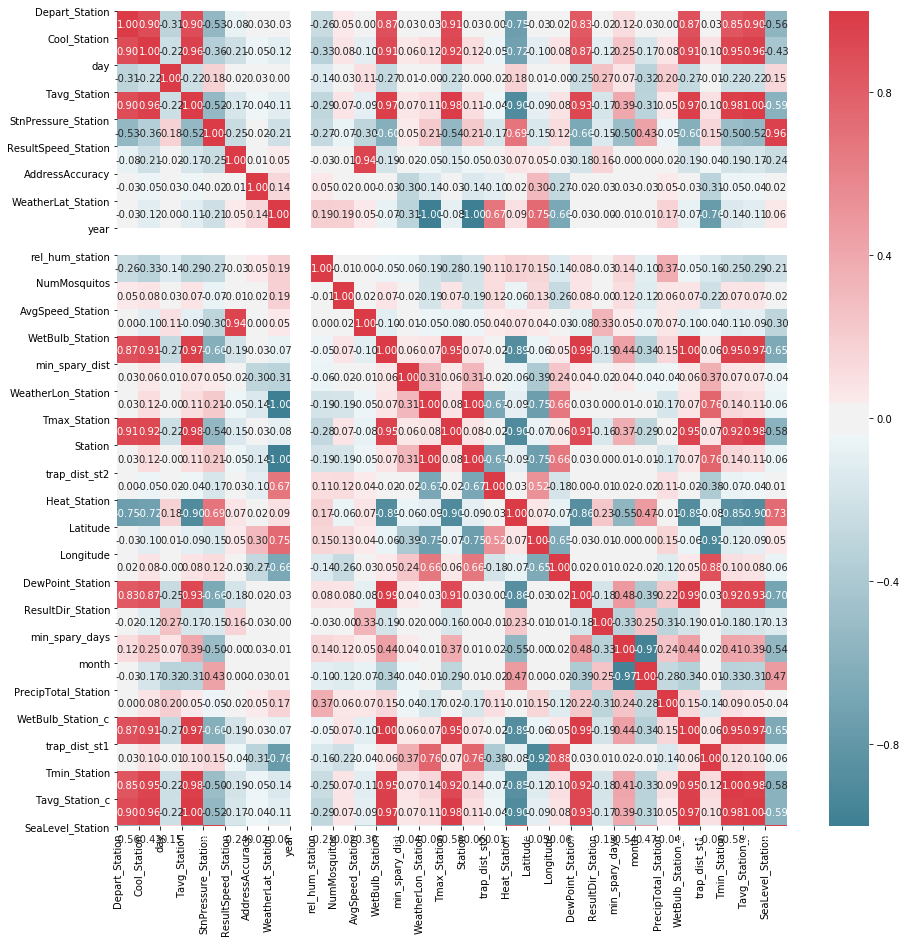

In [85]:
heatMap(numeric_df[numeric_df.year == 2011])

### Cor Matrix 2013 Before Spray

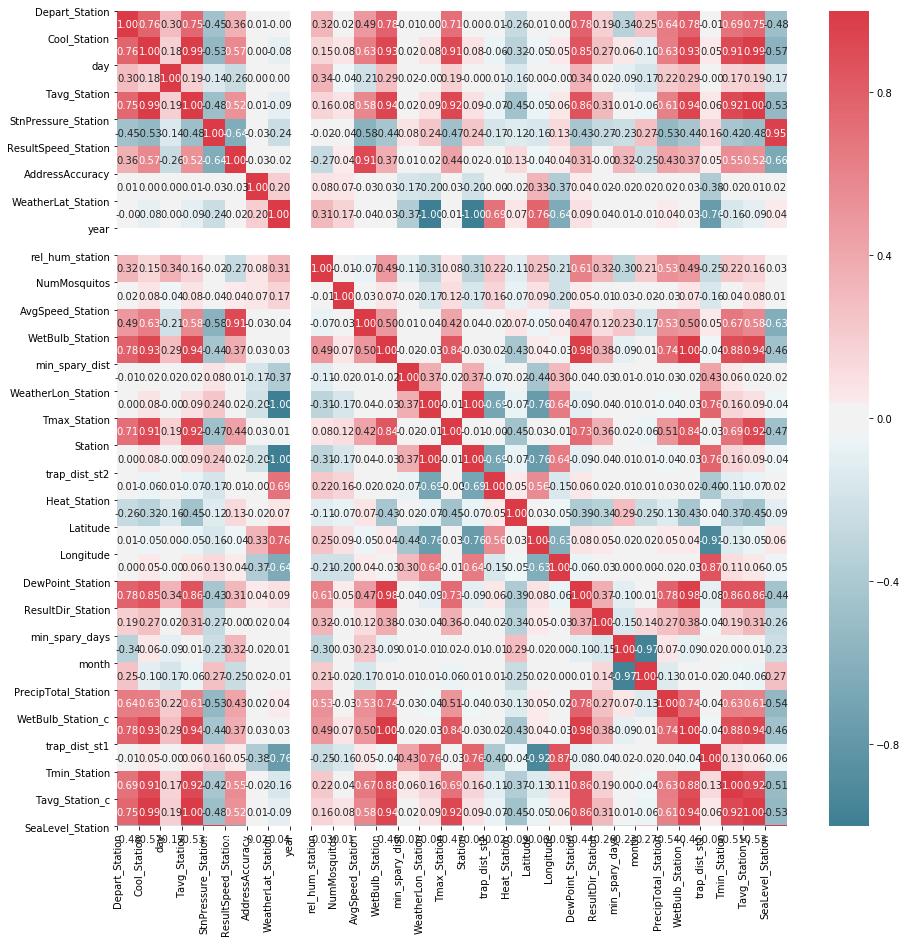

In [86]:
heatMap(numeric_df[numeric_df.year == 2013])

### Cor Matrix All

result : a lot of collinearity


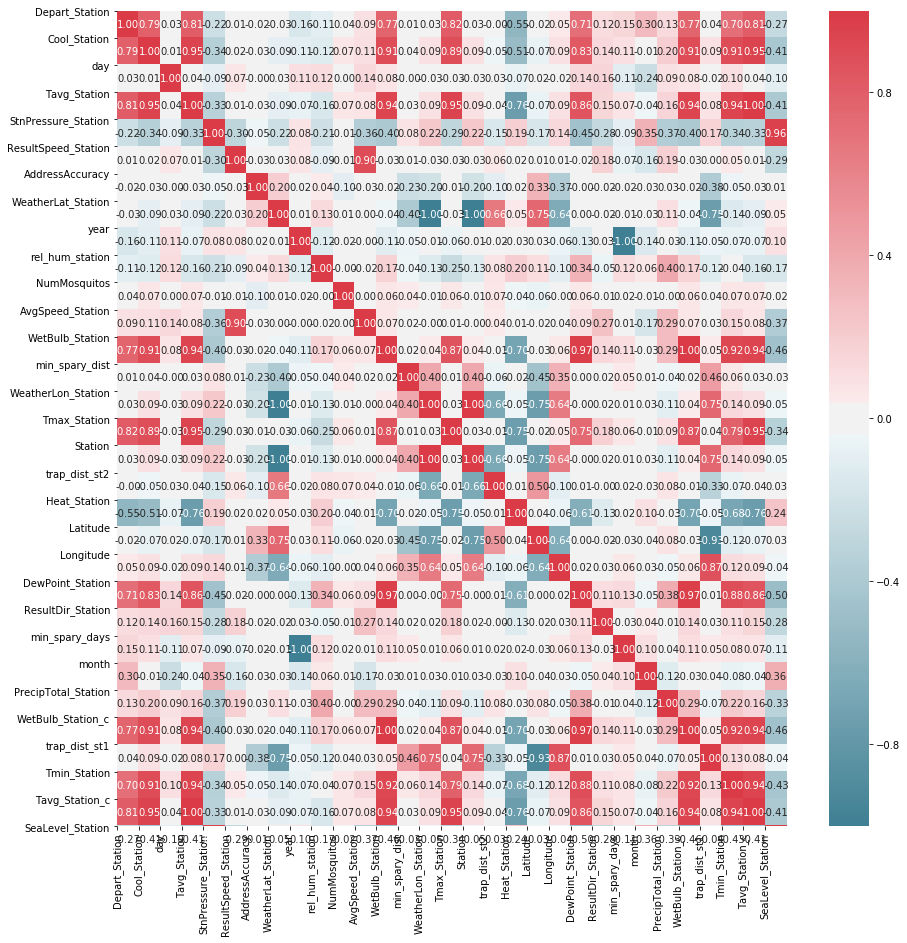

In [87]:
print("result : a lot of collinearity")

numeric_df = master_database1[num_col]._get_numeric_data()
heatMap(numeric_df)

## Normalizing Numeric Variables and Conducting VIF Test

In [88]:
def norm_func(i):
        r = (i-min(i))/(max(i)-min(i))
        return(r)

In [89]:
numeric_df = numeric_df.apply(norm_func)

In [90]:
numeric_df_norm = add_constant(numeric_df)
pd.options.display.float_format = "{:.2f}".format
VIF = pd.DataFrame({'Variable_Name' : numeric_df_norm.columns,
              'VIF':[round(variance_inflation_factor(numeric_df_norm.values, i),0)
                       for i in range(numeric_df_norm.shape[1])]})
VIF

,Variable_Name,VIF
0,const,0.00
1,Depart_Station,8.00
2,Cool_Station,6028915163816.00
3,day,1070.00
4,Tavg_Station,5077338926010.00
5,StnPressure_Station,107.00
6,ResultSpeed_Station,7.00
7,AddressAccuracy,1.00
8,WeatherLat_Station,7791694857042.00
9,year,10242875.00


In [91]:
print("Variables without Collinearity to Keep for Model :")
VIF1 = VIF[VIF.VIF <= 10].reset_index(drop=True)
VIF1

Variables without Collinearity to Keep for Model :


,Variable_Name,VIF
0,const,0.00
1,Depart_Station,8.00
2,ResultSpeed_Station,7.00
3,AddressAccuracy,1.00
4,NumMosquitos,1.00
5,AvgSpeed_Station,8.00
6,min_spary_dist,1.00
7,trap_dist_st2,3.00
8,ResultDir_Station,2.00
9,PrecipTotal_Station,2.00


## Filtered Data Frame from ChiSquare Test and VIF 

In [92]:
#dropping all the orginal columns
#master_database1.drop(columns=list(numeric_df.columns),axis=1,inplace=True)

In [93]:
#then add the normalized columns
#master_database1=pd.merge(left=master_database1,right=numeric_df, how='inner', left_on=master_database1.index,right_on=numeric_df.index)

In [94]:
filtered_numcols = list(VIF[VIF.VIF > 10].Variable_Name)
filtered_catcols = list(chi_square_df['Variable Name'][chi_square_df['P-value'] > .05])

In [95]:
master_database1.drop(columns= filtered_numcols + filtered_catcols, axis = 1, inplace = True)
master_database1.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,AddressAccuracy,WnvPresent,NumMosquitos,...,Sunrise_Station,Sunset_Station,DZ,HZ,NO_EVENT,RA,TS,TSRA,VCTS,min_spary_dist
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",8,0,1,...,4:21:00,19:17:00,0,1,0,0,0,0,0,2.73
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",8,0,2,...,4:21:00,19:17:00,0,1,0,0,0,0,0,2.73
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",8,0,1,...,4:21:00,19:17:00,0,1,0,0,0,0,0,3.09
3,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",8,0,1,...,4:21:00,19:17:00,0,1,0,0,0,0,0,1.94
4,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",8,0,1,...,4:21:00,19:17:00,0,1,0,0,0,0,0,0.01
